# Causal Knowledge Transfer for Safe Reinforcement Learning

### Train Agents
#### Sumo Network File
When editing the sumo network (nets/simple_unprotected_right.net.xml) never edit the xml directly. Instead, go to nets/netconfig and make desired changes there. Generate the new net.xml by executing generate config.sh
#### Sumo Route File
This is part of the generate_config.sh now.
#### Reward Function
* TODO: Come up with a fitting reward function that penalises collisions
#### RL Training
* TODO: Come up with Hyperparameters for the training loop

**Desired Output: Trained_Model.zip**

### Creating the Sumo Environment

In [3]:
# Make sure SUMO_HOME is set!
sumo_home = %env SUMO_HOME
from pathlib import Path

FRICTION = 0.9
END_TIME = 3600
REPEAT_PERIOD = 10

config_directory = Path().joinpath('nets', 'simple_unprotected_right')
config_files = {
    'netccfg': config_directory.joinpath('simple_unprotected_right.netccfg'), 
    'duarcfg': config_directory.joinpath('simple_unprotected_right.duarcfg'),
    'net.xml': config_directory.joinpath('simple_unprotected_right.net.xml'),
    'rou.xml': config_directory.joinpath('simple_unprotected_right.rou.xml'),
    'routes.rou.xml': config_directory.joinpath('routes.rou.xml'),
    'config.rou.xml': config_directory.joinpath('config.rou.xml'),
}

findAllRoutes = Path(sumo_home).joinpath('tools', 'findAllRoutes.py')
vehicle2flow = Path(sumo_home).joinpath('tools', 'route', 'vehicle2flow.py')

! netconvert --configuration-file {config_files['netccfg']} --default.friction {FRICTION}

! python {findAllRoutes} -n {config_files['net.xml']} -o {config_files['routes.rou.xml']} -s southJunction,westJunction -t junctionEast,junctionNorth

! duarouter --configuration-file {config_files['duarcfg']}

! python {vehicle2flow} {config_files['config.rou.xml']} -o {config_files['rou.xml']} -e {END_TIME} -r {REPEAT_PERIOD}


Success.


Reading up to time step: 0.00
Reading up to time step: 200.00
Success.


In [4]:
from env.SumoEnvironmentGenerator import SumoEnvironmentGenerator
from pathlib import Path

environments = SumoEnvironmentGenerator(
    net_file=str(Path().joinpath('nets', 'simple_unprotected_right', 'simple_unprotected_right.net.xml')),
    route_file=str(Path().joinpath('nets', 'simple_unprotected_right', 'simple_unprotected_right.rou.xml')),
    sumocfg_file=str(Path().joinpath('nets', 'simple_unprotected_right', 'simple_unprotected_right.sumocfg')),
    duration=3600,
    learning_data_csv_name=str(Path().joinpath('env', 'training_data', 'output.csv')),
)

### Training and saving the Model

In [7]:
from stable_baselines3.a2c import A2C

%set_env LIBSUMO_AS_TRACI=1

%load_ext tensorboard
env = environments.get_training_env()
model = A2C(
    env=env,
    policy='MlpPolicy',
    # learning_rate=0.001,
    # learning_starts=0,
    # train_freq=1,
    # target_update_interval=500,
    # exploration_fraction=0.05,
    # exploration_final_eps=0.01,
    verbose=1,
    tensorboard_log='dqn_sumo_tensorboard'
)
model.learn(100_000, tb_log_name='a2c')
model.save(Path().joinpath('env', 'training_data', 'a2c'))

env: LIBSUMO_AS_TRACI=1
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to dqn_sumo_tensorboard\a2c_3
------------------------------------
| time/                 |          |
|    fps                | 62       |
|    iterations         | 100      |
|    time_elapsed       | 7        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.887   |
|    explained_variance | 0.562    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.102    |
|    value_loss         | 0.0286   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 720      |
|    ep_rew_mean        | 0        |
| time/                 |          |
|    fps                | 62       |
|    iteratio

Giving the model a test run in an evaluation environment

In [8]:
from stable_baselines3.a2c import A2C

env = environments.get_demonstration_env()
model = A2C(env=env, policy='MlpPolicy').load(Path().joinpath('env', 'training_data', 'a2c'))

obs, info = env.reset()
done = False
while not done:
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
env.close()

### Produce Traces
Run the simulation repeatably to produce traces (data) for causal discovery.

#### Data Selection
TODO: Select which columns we want to do Causal Discovery on
#### Data Summary
TODO: Incorporate old data summary script

**Desired Output: One CSV File containing all interesting data**


In [9]:
from stable_baselines3.a2c import A2C

simulation_output_path = Path().joinpath('data', 'a2c')
Path.mkdir(simulation_output_path, parents=True, exist_ok=True)

for experiment in range(100):
    env = environments.get_generation_env(output_prefix=str(simulation_output_path.joinpath(str(experiment).zfill(4))))
    model = A2C(env=env, policy='MlpPolicy').load(Path().joinpath('env', 'training_data', 'a2c'))

    obs, info = env.reset()
    done = False
    while not done:
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    env.close()

#### Data Summary

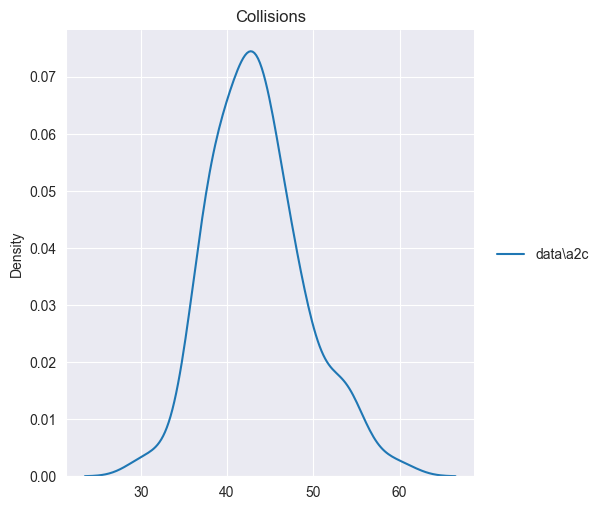

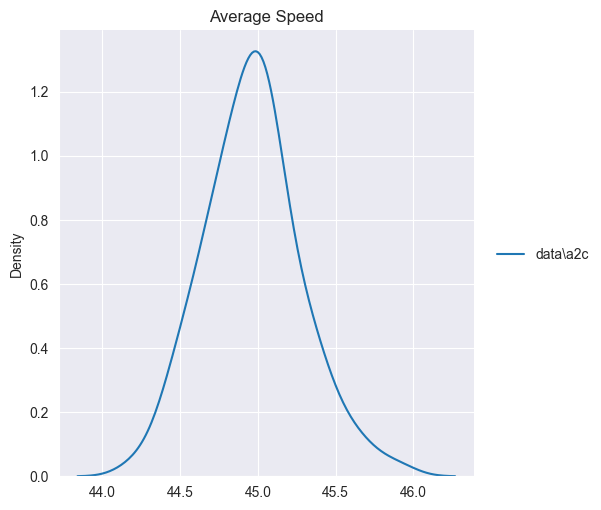

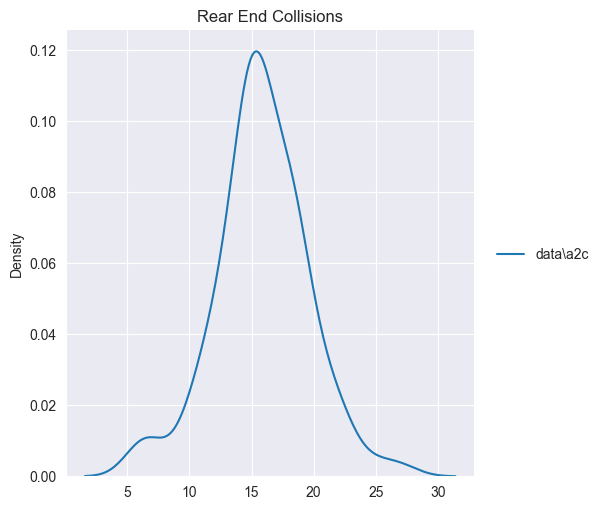

In [1]:
import glob
from pathlib import Path
import xml.etree.ElementTree as ElementTree
import pandas as pd
import seaborn as sns

data_folder = Path().joinpath('data')
experiments = glob.glob(str(data_folder.joinpath('*')))

collision_count = {}
average_speeds = {}
rear_end_collision_count = {}

for experiment in experiments:
    statistics_files = glob.glob(str(Path(experiment).joinpath('*_statistics.xml')))
    collision_files = glob.glob(str(Path(experiment).joinpath('*_collisions.xml')))
    collision_count[experiment] = []
    average_speeds[experiment] = []
    rear_end_collision_count[experiment] = []

    for statistics_file in statistics_files:
        statistics_root = ElementTree.parse(statistics_file).getroot()
        collisions = statistics_root.find('safety').attrib.get('collisions')
        average_speed = statistics_root.find('vehicleTripStatistics').attrib.get('speed')
        collision_count[experiment].append(int(collisions))
        average_speeds[experiment].append(float(average_speed) * 3.6)

    for collision_file in collision_files:
        collision_root = ElementTree.parse(collision_file).getroot()
        rear_end_collisions = sum('southEast' in child.attrib.get('victim') for child in collision_root)
        rear_end_collision_count[experiment].append(int(rear_end_collisions))

collision_count = pd.DataFrame.from_dict(collision_count)
average_speeds = pd.DataFrame.from_dict(average_speeds)
rear_end_collision_count = pd.DataFrame.from_dict(rear_end_collision_count)
sns.displot(collision_count, kind='kde').set(title='Collisions')
sns.displot(average_speeds, kind='kde').set(title='Average Speed')
sns.displot(rear_end_collision_count, kind='kde').set(title='Rear End Collisions')


### Causal Discovery
Discover causal graph

TODO: Decide which discovery algorithm to use

TODO: Figure out how to incorporate R code in Jupyter Notebook

**Desired Output: Causal Graph XML File**

In [ ]:
# TODO

### Fit MLMs
Fit MLMs based on Causal Discovery Graph

TODO: Parse Graph XML into MLM parameters / formulae

**Desired Output: MLM**

In [ ]:
# TODO

### Produce Interventions

#### Covariate Shift Distribution
* Create a distribution for the covariate (friction) shift
* Sample from distribution
    * Fulfill Assumption: sparse sample data is representative for covariate shift ground truth
* Produce Traces for sparse input data

#### Crank MLM the other way
* Calculate Intervention Distribution by inputting sparse data into MLM

**Desired Output: Intervention Distribution**

In [ ]:
# TODO

### Generate Posterior Distributions
TODO: Generate Posterior Distributions without intervention

TODO: Generate Posterior Distributions with intervention

**Desired Output: Two XML Files**

In [ ]:
# TODO

### Query
Compare Distributions and decide, which part of the model to retrain.

TODO: Classify the data / model in parts

In [ ]:
# TODO

### Evaluation

#### Agent
compare new resulting agent (partially continued training depending on Query) to:
* Old agent (Lower performance bound)
* Completely newly trained agent (upper performance bound)
* (New Agent that is trained completely on new data (without Query))

#### Intervention
Function: Number of Covariate Shift Samples --> Wasserstein distance: Intervention vs. ground truth (distribution)

#### MLM
* Wasserstein Distance: Effect of Intervention vs. ground truth effect
* Maybe also as a function of the number of retrain samples



In [ ]:
# TODO

### Ideas
* Maybe no change in friction but rather only in the requirements
* Sophisticated Query: Causal Graph of Transfer Learning --> Generate Posterior for different transfer learning options --> Rank and choose best.
* Collision / Penalty Factor for managing Safety/Performance tradeoff